# Backtesting Mercury Challenge Time Series Baserate Models

This notebook illustrates a backtest of the Mercury Challenge Baserate models for the Case Count events.  See [Developing Mercury Time Series Models](./Fit%20CU%20Time%20Series%20Models.ipynb) for model development details.

In [1]:
pwd

'/Users/peterhaglich/Dropbox/Work/IARPA/Mercury/peterhaglich/mercury-challenge/src/Baserate/notebooks'

In [2]:
%matplotlib inline

In [3]:
import os
import json
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import (plot_acf, plot_pacf)
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
import datetime
from dateutil.parser import parse
import sys
sys.path.append(("../.."))
from Baserate.main.timeseries import (
    evaluate_arima_model, 
    evaluate_models, 
    mean_qs_error, 
    TsDefaults,
    one_step_ahead_forecast,
    hist_avg_predict,
    future_dates
)
from ExpressScore.main.express_score import CaseCountScorer
import warnings
warnings.filterwarnings("ignore")

import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use("fivethirtyeight");

In [4]:
EVT_ABBR = "CU"
EVT_TYPE = "Civil Unrest"
MC_HOME = os.path.abspath("../../..")
DOC_PATH = os.path.join(MC_HOME, "doc")
EVT_DOC_PATH = os.path.join(DOC_PATH, "scoring", EVT_ABBR)
DATA_PATH = os.path.join(MC_HOME, "data")
GSR_PATH = os.path.join(DATA_PATH, "gsr")
CU_COUNT_GSR_PATH = os.path.join(GSR_PATH, "cu_count_gsr")
WARN_PATH = os.path.join(DATA_PATH, "baserate_warnings")
CU_WARN_PATH = os.path.join(WARN_PATH, "baserate_cu_warnings")
RESOURCE_PATH = os.path.join(MC_HOME, "src", "Baserate", "resources")
MODEL_EVAL_FILENAME = "TS Model Parameters.json"
model_eval_filepath = os.path.join(RESOURCE_PATH, MODEL_EVAL_FILENAME)
with open(model_eval_filepath, "r") as f:
    model_eval_dict = json.load(f)
TRAIN_START_DATE = "2015-05-01"
TEST_START_DATE = "2018-09-19"
WARN_START_DATE = "2018-10-05"
WARN_END_DATE = "2018-10-18"
test_range = pd.date_range(TEST_START_DATE, WARN_END_DATE)
warn_range = pd.date_range(WARN_START_DATE, WARN_END_DATE)
warn_months = [dd.strftime("%B_%Y") for dd in warn_range]
warn_months = list(pd.Series(warn_months).unique())
PARTICIPANT_ID = "Mercury_Baserate"

P_MAX = TsDefaults.P_MAX # Up to lag 4
D_MAX = TsDefaults.D_MAX # Up to the first difference
Q_MAX = TsDefaults.Q_MAX # Up to lag 4

In [5]:
warn_months

['October_2018']

## Egypt Daily CU

In [6]:
place, freq = ("Egypt", "Daily")
model_details = model_eval_dict[place]
print(model_details)

{'Model_Params': [5.348368567013427, 1.3043697162287806, -0.3267554866621827, -0.8888925988013819], 'Order': [2, 0, 1], 'Error': 0.4152948681735336}


A plot of the case counts over time is shown below.

Data from 2015-05-01 00:00:00 to 2018-09-18 00:00:00


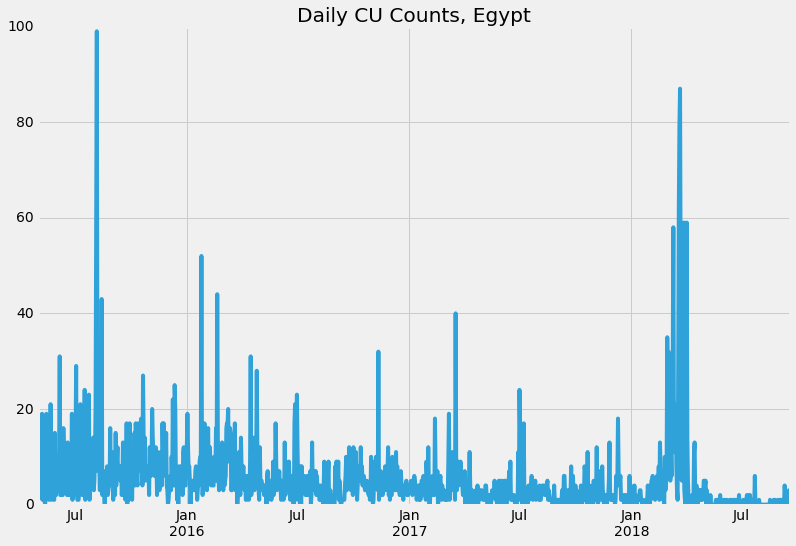

In [7]:
filename_ = "{0}_{1}_Counts.json".format(place, freq)
filepath_ = os.path.join(CU_COUNT_GSR_PATH, filename_)
with open(filepath_, "r", encoding="utf8") as f:
    gsr_ = json.load(f)
count_dict = {parse(e["Event_Date"]): e["Case_Count"] for e in gsr_}
count_ser = pd.Series(count_dict)
count_ser.plot(figsize=(12,8))
print("Data from {0} to {1}".format(count_ser.index[0], count_ser.index[-1]))
plt.title("{0} CU Counts, {1}".format(freq, place));

Train the model using the order from the archived order dictionary and the data from the train range.  Predict for the test range but only use the warnings from the warning range.

In [8]:
train = count_ser[:TEST_START_DATE]
order = model_eval_dict[place]["Order"]
if order != [0,0,0]:
    try:
        model = sm.tsa.ARIMA(endog=train, order=order)
        model_fit = model.fit(disp=0)
    except ValueError:
        model_eval = evaluate_models(train, range(P_MAX+1), 
                                     range(d_max+1), range(Q_MAX+1), 
                                     verbose=False)
        order = model_eval["Order"]
        print("Had to retrain, new order is ", order)
        model_eval_dict[place] = model_eval
        model = sm.tsa.ARIMA(endog=train, order=order)
        model_fit = model.fit(disp=0)
    predict = model_fit.forecast(steps=len(test_range))[0]
else:
    historical_mean = train.mean()
    predict = [historical_mean]*len(test_range)
predict = [round(p) for p in predict]
predict_ser = pd.Series(predict, index=test_range)
warn_ser = predict_ser[warn_range]
warn_df = pd.DataFrame({"Event_Date": warn_ser.index, "Case_Count": warn_ser,
                        "Country": "Egypt", "Event_Type": EVT_TYPE})
warn_df["timestamp"] = (parse(TEST_START_DATE) - datetime.timedelta(1)).strftime("%Y-%m-%d")
warn_df.timestamp = warn_df.timestamp.apply(lambda t: t+"T12:00:00.1")
warn_df["Warning_ID"] = warn_df.apply(lambda x: "BR_CU_{0}_{1}".format(place, 
                                                        x.Event_Date.strftime("%Y-%m-%d")),
                                                    axis=1)


warn_df

,Case_Count,Country,Event_Date,Event_Type,timestamp,Warning_ID
2018-10-05,3.0,Egypt,2018-10-05,Civil Unrest,2018-09-18T12:00:00.1,BR_CU_Egypt_2018-10-05
2018-10-06,3.0,Egypt,2018-10-06,Civil Unrest,2018-09-18T12:00:00.1,BR_CU_Egypt_2018-10-06
2018-10-07,3.0,Egypt,2018-10-07,Civil Unrest,2018-09-18T12:00:00.1,BR_CU_Egypt_2018-10-07
2018-10-08,3.0,Egypt,2018-10-08,Civil Unrest,2018-09-18T12:00:00.1,BR_CU_Egypt_2018-10-08
2018-10-09,3.0,Egypt,2018-10-09,Civil Unrest,2018-09-18T12:00:00.1,BR_CU_Egypt_2018-10-09
2018-10-10,4.0,Egypt,2018-10-10,Civil Unrest,2018-09-18T12:00:00.1,BR_CU_Egypt_2018-10-10
2018-10-11,4.0,Egypt,2018-10-11,Civil Unrest,2018-09-18T12:00:00.1,BR_CU_Egypt_2018-10-11
2018-10-12,4.0,Egypt,2018-10-12,Civil Unrest,2018-09-18T12:00:00.1,BR_CU_Egypt_2018-10-12
2018-10-13,4.0,Egypt,2018-10-13,Civil Unrest,2018-09-18T12:00:00.1,BR_CU_Egypt_2018-10-13
2018-10-14,4.0,Egypt,2018-10-14,Civil Unrest,2018-09-18T12:00:00.1,BR_CU_Egypt_2018-10-14


In [9]:
out_filename = "BR_Warnings_{0}_{1}_to_{2}.json".format(place, WARN_START_DATE, WARN_END_DATE)
out_path = os.path.join(CU_WARN_PATH, place, out_filename)


warn_json = warn_df.to_json(force_ascii=False, orient="records", 
                                    date_format="iso", path_or_buf=out_path)
with open(out_path, "r", encoding="utf-8-sig") as f:
    warn_json = json.load(f)
    for k in warn_json:
        k["Event_Date"] = k["Event_Date"][:10]


out_json = {"payload": warn_json, "participant_id": PARTICIPANT_ID}
with open(out_path, "w") as f:
    json.dump(out_json, f, ensure_ascii=False, indent=2)

In [10]:
freq = "Weekly"

## Tahrir Weekly CU

In [11]:
place = "Tahrir"
model_details = model_eval_dict[place]
print(model_details)

{'Model_Params': [13.219405392902976, 0.6914315123177581, -0.1998999938525163, -0.15440225073141006, 0.22803605306536565], 'Order': [1, 0, 3], 'Error': 0.45546648460232236}


Data from 2015-04-29 00:00:00 to 2018-09-12 00:00:00


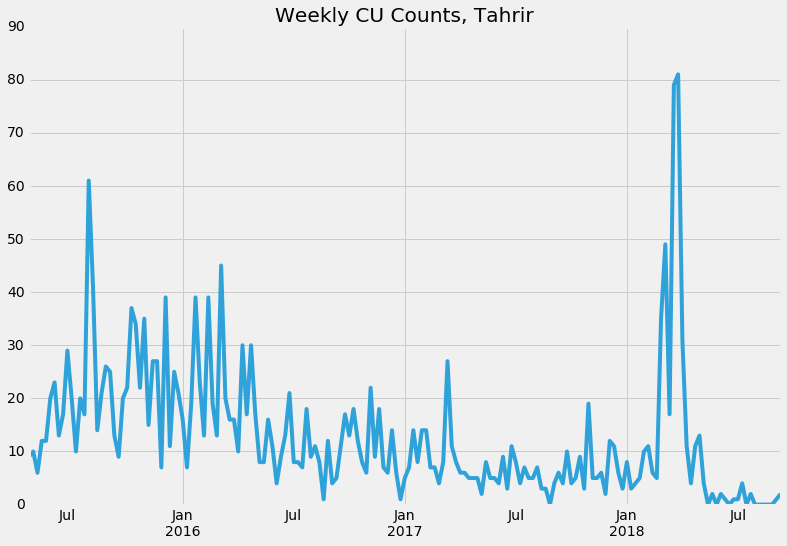

In [12]:
filename_ = "{0}_{1}_Counts.json".format(place, freq)
filepath_ = os.path.join(CU_COUNT_GSR_PATH, filename_)
with open(filepath_, "r", encoding="utf8") as f:
    gsr_ = json.load(f)
count_dict = {parse(e["Event_Date"]): e["Case_Count"] for e in gsr_}
count_ser = pd.Series(count_dict)
count_ser.plot(figsize=(12,8))
print("Data from {0} to {1}".format(count_ser.index[0], count_ser.index[-1]))
plt.title("{0} CU Counts, {1}".format(freq, place));

In [13]:
count_ser.tail()

2018-08-15    0.0
2018-08-22    0.0
2018-08-29    0.0
2018-09-05    1.0
2018-09-12    2.0
dtype: float64

In [14]:
test_range = pd.date_range(TEST_START_DATE, WARN_END_DATE, freq=TsDefaults.CU_WEEKLY_FREQ)
print(test_range)
warn_range = pd.date_range(WARN_START_DATE, WARN_END_DATE, freq=TsDefaults.CU_WEEKLY_FREQ)
warn_range

DatetimeIndex(['2018-09-19', '2018-09-26', '2018-10-03', '2018-10-10',
               '2018-10-17'],
              dtype='datetime64[ns]', freq='W-WED')


DatetimeIndex(['2018-10-10', '2018-10-17'], dtype='datetime64[ns]', freq='W-WED')

In [15]:
train = count_ser[:TEST_START_DATE]
order = model_eval_dict[place]["Order"]
if order != [0,0,0]:
    try:
        model = sm.tsa.ARIMA(endog=train, order=order)
        model_fit = model.fit(disp=0)
    except ValueError:
        model_eval = evaluate_models(train, range(P_MAX+1), 
                                     range(D_MAX+1), range(Q_MAX+1), 
                                     verbose=False)
        order = model_eval["Order"]
        print("Had to retrain, new order is ", order)
        model_eval_dict[place] = model_eval
        model = sm.tsa.ARIMA(endog=train, order=order)
        model_fit = model.fit(disp=0)
    predict = model_fit.forecast(steps=len(test_range))[0]
else:
    historical_mean = train.mean()
    predict = [historical_mean]*len(test_range)
predict = [round(p) for p in predict]
predict_ser = pd.Series(predict, index=test_range)
print(predict_ser)
warn_ser = predict_ser[warn_range]
warn_df = pd.DataFrame({"Event_Date": warn_ser.index, "Case_Count": warn_ser,
                        "Country": "Egypt", "Event_Type": EVT_TYPE,
                        "City": "Tahrir Square"})
warn_df["timestamp"] = (parse(TEST_START_DATE) - datetime.timedelta(1)).strftime("%Y-%m-%d")
warn_df.timestamp = warn_df.timestamp.apply(lambda t: t+"T12:00:00.1")
warn_df["Warning_ID"] = warn_df.apply(lambda x: "BR_CU_{0}_{1}".format(place, 
                                                        x.Event_Date.strftime("%Y-%m-%d")),
                                                    axis=1)


warn_df

2018-09-19     5.0
2018-09-26     7.0
2018-10-03     8.0
2018-10-10     9.0
2018-10-17    10.0
Freq: W-WED, dtype: float64


,Case_Count,City,Country,Event_Date,Event_Type,timestamp,Warning_ID
2018-10-10,9.0,Tahrir Square,Egypt,2018-10-10,Civil Unrest,2018-09-18T12:00:00.1,BR_CU_Tahrir_2018-10-10
2018-10-17,10.0,Tahrir Square,Egypt,2018-10-17,Civil Unrest,2018-09-18T12:00:00.1,BR_CU_Tahrir_2018-10-17


In [16]:
out_filename = "BR_Warnings_{0}_{1}_to_{2}.json".format(place, WARN_START_DATE, WARN_END_DATE)
out_path = os.path.join(CU_WARN_PATH, place, out_filename)


warn_json = warn_df.to_json(force_ascii=False, orient="records", 
                                    date_format="iso", path_or_buf=out_path)
with open(out_path, "r", encoding="utf-8-sig") as f:
    warn_json = json.load(f)
    for k in warn_json:
        k["Event_Date"] = k["Event_Date"][:10]


out_json = {"payload": warn_json, "participant_id": PARTICIPANT_ID}
with open(out_path, "w") as f:
    json.dump(out_json, f, ensure_ascii=False, indent=2)

## Jordan Weekly CU

In [17]:
place = "Jordan"
model_details = model_eval_dict[place]
print(model_details)

{'Model_Params': [11.027921685059578, 0.4502484516492988, -0.15446368628884596, 0.06735044515885791, -0.03486694497046559], 'Order': [4, 0, 0], 'Error': 0.44692563630220655}


Data from 2015-04-29 00:00:00 to 2018-09-12 00:00:00


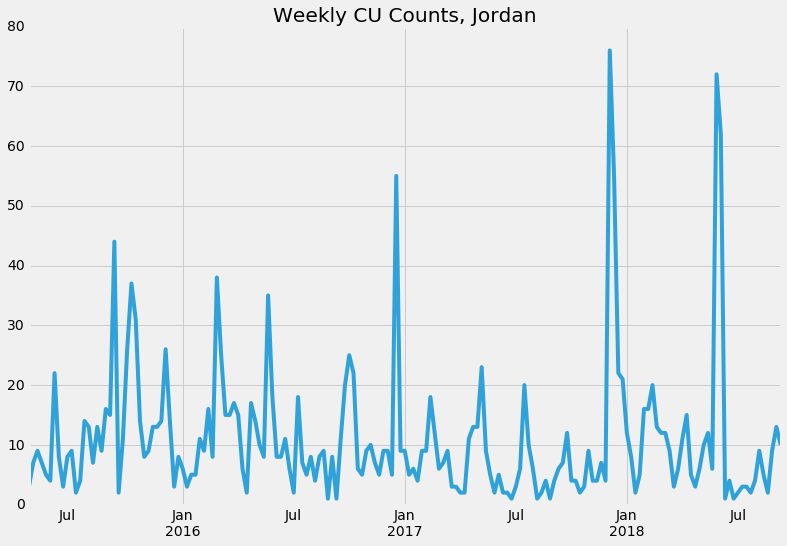

In [18]:
filename_ = "{0}_{1}_Counts.json".format(place, freq)
filepath_ = os.path.join(CU_COUNT_GSR_PATH, filename_)
with open(filepath_, "r", encoding="utf8") as f:
    gsr_ = json.load(f)
count_dict = {parse(e["Event_Date"]): e["Case_Count"] for e in gsr_}
count_ser = pd.Series(count_dict)
count_ser = 1.0*count_ser
count_ser.plot(figsize=(12,8))
print("Data from {0} to {1}".format(count_ser.index[0], count_ser.index[-1]))
plt.title("{0} CU Counts, {1}".format(freq, place));

In [19]:
count_ser.tail()

2018-08-15     5.0
2018-08-22     2.0
2018-08-29     9.0
2018-09-05    13.0
2018-09-12    10.0
dtype: float64

In [20]:
test_range = pd.date_range(TEST_START_DATE, WARN_END_DATE, freq=TsDefaults.CU_WEEKLY_FREQ)
print(test_range)
warn_range = pd.date_range(WARN_START_DATE, WARN_END_DATE, freq=TsDefaults.CU_WEEKLY_FREQ)
warn_range

DatetimeIndex(['2018-09-19', '2018-09-26', '2018-10-03', '2018-10-10',
               '2018-10-17'],
              dtype='datetime64[ns]', freq='W-WED')


DatetimeIndex(['2018-10-10', '2018-10-17'], dtype='datetime64[ns]', freq='W-WED')

In [21]:
train = count_ser[:TEST_START_DATE]
order = model_eval_dict[place]["Order"]
if order != [0,0,0]:
    try:
        model = sm.tsa.ARIMA(endog=train, order=order)
        model_fit = model.fit(disp=0)
    except ValueError:
        model_eval = evaluate_models(train, range(P_MAX+1), 
                                     range(d_max+1), range(Q_MAX+1), 
                                     verbose=False)
        order = model_eval["Order"]
        print("Had to retrain, new order is ", order)
        model_eval_dict[place] = model_eval
        model = sm.tsa.ARIMA(endog=train, order=order)
        model_fit = model.fit(disp=0)
    predict = model_fit.forecast(steps=len(test_range))[0]
else:
    historical_mean = train.mean()
    predict = [historical_mean]*len(test_range)
predict = [round(p) for p in predict]
predict_ser = pd.Series(predict, index=test_range)
print(predict_ser)
warn_ser = predict_ser[warn_range]
warn_df = pd.DataFrame({"Event_Date": warn_ser.index, "Case_Count": warn_ser,
                        "Country": "Jordan", "Event_Type": EVT_TYPE})
warn_df["timestamp"] = (parse(TEST_START_DATE) - datetime.timedelta(1)).strftime("%Y-%m-%d")
warn_df.timestamp = warn_df.timestamp.apply(lambda t: t+"T12:00:00.1")
warn_df["Warning_ID"] = warn_df.apply(lambda x: "BR_CU_{0}_{1}".format(place, 
                                                        x.Event_Date.strftime("%Y-%m-%d")),
                                                    axis=1)


warn_df

2018-09-19    11.0
2018-09-26    11.0
2018-10-03    11.0
2018-10-10    11.0
2018-10-17    11.0
Freq: W-WED, dtype: float64


,Case_Count,Country,Event_Date,Event_Type,timestamp,Warning_ID
2018-10-10,11.0,Jordan,2018-10-10,Civil Unrest,2018-09-18T12:00:00.1,BR_CU_Jordan_2018-10-10
2018-10-17,11.0,Jordan,2018-10-17,Civil Unrest,2018-09-18T12:00:00.1,BR_CU_Jordan_2018-10-17


In [22]:
out_filename = "BR_Warnings_{0}_{1}_to_{2}.json".format(place, WARN_START_DATE, WARN_END_DATE)
out_path = os.path.join(CU_WARN_PATH, place, out_filename)


warn_json = warn_df.to_json(force_ascii=False, orient="records", 
                                    date_format="iso", path_or_buf=out_path)
with open(out_path, "r", encoding="utf-8-sig") as f:
    warn_json = json.load(f)
    for k in warn_json:
        k["Event_Date"] = k["Event_Date"][:10]


out_json = {"payload": warn_json, "participant_id": PARTICIPANT_ID}
with open(out_path, "w") as f:
    json.dump(out_json, f, ensure_ascii=False, indent=2)

In [23]:
freq = "Monthly"

## Amman Monthly CU

In [24]:
place="Amman"
model_details = model_eval_dict[place]
print(model_details)

{'Model_Params': [12.945945945945951], 'Order': [0, 0, 0], 'Error': 0.3778763971071663}


In [25]:
# Convert the ranges to month ranges

test_range = pd.date_range(TEST_START_DATE, WARN_END_DATE, freq="MS")
print(test_range)
warn_range = pd.date_range(WARN_START_DATE, WARN_END_DATE, freq="MS")
warn_range

DatetimeIndex(['2018-10-01'], dtype='datetime64[ns]', freq='MS')


DatetimeIndex([], dtype='datetime64[ns]', freq='MS')

Data from 2015-05-01 00:00:00 to 2018-08-01 00:00:00


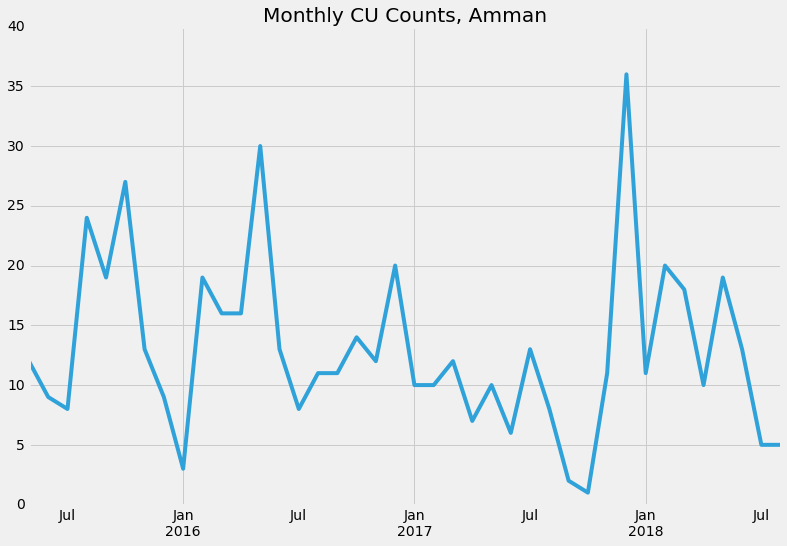

In [26]:
filename_ = "{0}_{1}_Counts.json".format(place, freq)
filepath_ = os.path.join(CU_COUNT_GSR_PATH, filename_)
with open(filepath_, "r", encoding="utf8") as f:
    gsr_ = json.load(f)
count_dict = {parse(e["Event_Date"]): e["Case_Count"] for e in gsr_}
count_ser = pd.Series(count_dict)
count_ser.plot(figsize=(12,8))
print("Data from {0} to {1}".format(count_ser.index[0], count_ser.index[-1]))
plt.title("{0} CU Counts, {1}".format(freq, place));

In [27]:
train = count_ser[:TEST_START_DATE]
order = model_eval_dict[place]["Order"]
if order != [0,0,0]:
    try:
        model = sm.tsa.ARIMA(endog=train, order=order)
        model_fit = model.fit(disp=0)
    except ValueError:
        model_eval = evaluate_models(count_ser, range(P_MAX+1), 
                                     range(d_max+1), range(Q_MAX+1), 
                                     verbose=False)
        order = model_eval["Order"]
        print("Had to retrain, new order is ", order)
        model_eval_dict[place] = model_eval
        model = sm.tsa.ARIMA(endog=train, order=order)
        model_fit = model.fit(disp=0)
    predict = model_fit.forecast(steps=len(test_range))[0]
else:
    historical_mean = train.mean()
    predict = [historical_mean]*len(test_range)
predict = [round(p) for p in predict]
predict_ser = pd.Series(predict, index=test_range)
print(predict_ser)
warn_ser = predict_ser[warn_range]
warn_df = pd.DataFrame({"Event_Date": warn_ser.index, "Case_Count": warn_ser,
                        "Country": "Jordan", "State": place, "Event_Type": EVT_TYPE})
warn_df["timestamp"] = (parse(TEST_START_DATE) - datetime.timedelta(1)).strftime("%Y-%m-%d")
warn_df.timestamp = warn_df.timestamp.apply(lambda t: t+"T12:00:00.1")
warn_df["Warning_ID"] = warn_df.apply(lambda x: "BR_CU_{0}_{1}".format(place, 
                                                        x.Event_Date.strftime("%Y-%m-%d")),
                                                    axis=1)


warn_df

2018-10-01    13.0
Freq: MS, dtype: float64


ValueError: Cannot set a frame with no defined index and a value that cannot be converted to a Series

In [ ]:
out_filename = "BR_Warnings_{0}_{1}.json".format(place, warn_months[-1])
out_path = os.path.join(CU_WARN_PATH, place, out_filename)


warn_json = warn_df.to_json(force_ascii=False, orient="records", 
                                    date_format="iso", path_or_buf=out_path)
with open(out_path, "r", encoding="utf-8-sig") as f:
    warn_json = json.load(f)
    for k in warn_json:
        k["Event_Date"] = k["Event_Date"][:10]


out_json = {"payload": warn_json, "participant_id": PARTICIPANT_ID}
with open(out_path, "w") as f:
    json.dump(out_json, f, ensure_ascii=False, indent=2)

## Irbid Monthly CU

In [ ]:
place="Irbid"
model_details = model_eval_dict[place]
print(model_details)

In [ ]:
filename_ = "{0}_{1}_Counts.json".format(place, freq)
filepath_ = os.path.join(CU_COUNT_GSR_PATH, filename_)
with open(filepath_, "r", encoding="utf8") as f:
    gsr_ = json.load(f)
count_dict = {parse(e["Event_Date"]): e["Case_Count"] for e in gsr_}
count_ser = pd.Series(count_dict)
count_ser.plot(figsize=(12,8))
print("Data from {0} to {1}".format(count_ser.index[0], count_ser.index[-1]))
plt.title("{0} CU Counts, {1}".format(freq, place));

In [ ]:
train = count_ser[:TEST_START_DATE]
order = model_eval_dict[place]["Order"]
if order != [0,0,0]:
    try:
        model = sm.tsa.ARIMA(endog=train, order=order)
        model_fit = model.fit(disp=0)
    except ValueError:
        model_eval = evaluate_models(count_ser, range(P_MAX+1), 
                                     range(d_max+1), range(Q_MAX+1), 
                                     verbose=False)
        order = model_eval["Order"]
        print("Had to retrain, new order is ", order)
        model_eval_dict[place] = model_eval
        model = sm.tsa.ARIMA(endog=train, order=order)
        model_fit = model.fit(disp=0)
    predict = model_fit.forecast(steps=len(test_range))[0]
else:
    historical_mean = train.mean()
    predict = [historical_mean]*len(test_range)
predict = [round(p) for p in predict]
predict_ser = pd.Series(predict, index=test_range)
print(predict_ser)
warn_ser = predict_ser[warn_range]
warn_df = pd.DataFrame({"Event_Date": warn_ser.index, "Case_Count": warn_ser,
                        "Country": "Jordan", "State": place, "Event_Type": EVT_TYPE})
warn_df["timestamp"] = (parse(TEST_START_DATE) - datetime.timedelta(1)).strftime("%Y-%m-%d")
warn_df.timestamp = warn_df.timestamp.apply(lambda t: t+"T12:00:00.1")
warn_df["Warning_ID"] = warn_df.apply(lambda x: "BR_CU_{0}_{1}".format(place, 
                                                        x.Event_Date.strftime("%Y-%m-%d")),
                                                    axis=1)


warn_df

In [ ]:
out_filename = "BR_Warnings_{0}_{1}.json".format(place, warn_months[-1])
out_path = os.path.join(CU_WARN_PATH, place, out_filename)


warn_json = warn_df.to_json(force_ascii=False, orient="records", 
                                    date_format="iso", path_or_buf=out_path)
with open(out_path, "r", encoding="utf-8-sig") as f:
    warn_json = json.load(f)
    for k in warn_json:
        k["Event_Date"] = k["Event_Date"][:10]


out_json = {"payload": warn_json, "participant_id": PARTICIPANT_ID}
with open(out_path, "w") as f:
    json.dump(out_json, f, ensure_ascii=False, indent=2)

## Madaba Monthly CU

In [ ]:
place = "Madaba"
model_details = model_eval_dict[place]
print(model_details)

In [ ]:
filename_ = "{0}_{1}_Counts.json".format(place, freq)
filepath_ = os.path.join(CU_COUNT_GSR_PATH, filename_)
with open(filepath_, "r", encoding="utf8") as f:
    gsr_ = json.load(f)
count_dict = {parse(e["Event_Date"]): e["Case_Count"] for e in gsr_}
count_ser = pd.Series(count_dict)
count_ser.plot(figsize=(12,8))
print("Data from {0} to {1}".format(count_ser.index[0], count_ser.index[-1]))
plt.title("{0} CU Counts, {1}".format(freq, place));

In [ ]:
train = count_ser[:TEST_START_DATE]
order = model_eval_dict[place]["Order"]
if order != [0,0,0]:
    try:
        model = sm.tsa.ARIMA(endog=train, order=order)
        model_fit = model.fit(disp=0)
    except ValueError:
        model_eval = evaluate_models(count_ser, range(P_MAX+1), 
                                     range(d_max+1), range(Q_MAX+1), 
                                     verbose=False)
        order = model_eval["Order"]
        print("Had to retrain, new order is ", order)
        model_eval_dict[place] = model_eval
        model = sm.tsa.ARIMA(endog=train, order=order)
        model_fit = model.fit(disp=0)
    predict = model_fit.forecast(steps=len(test_range))[0]
else:
    historical_mean = train.mean()
    predict = [historical_mean]*len(test_range)
predict = [round(p) for p in predict]
predict_ser = pd.Series(predict, index=test_range)
print(predict_ser)
warn_ser = predict_ser[warn_range]
warn_df = pd.DataFrame({"Event_Date": warn_ser.index, "Case_Count": warn_ser,
                        "Country": "Jordan", "State": place, "Event_Type": EVT_TYPE})
warn_df["timestamp"] = (parse(TEST_START_DATE) - datetime.timedelta(1)).strftime("%Y-%m-%d")
warn_df.timestamp = warn_df.timestamp.apply(lambda t: t+"T12:00:00.1")
warn_df["Warning_ID"] = warn_df.apply(lambda x: "BR_CU_{0}_{1}".format(place, 
                                                        x.Event_Date.strftime("%Y-%m-%d")),
                                                    axis=1)


warn_df

In [ ]:
out_filename = "BR_Warnings_{0}_{1}.json".format(place, warn_months[-1])
out_path = os.path.join(CU_WARN_PATH, place, out_filename)


warn_json = warn_df.to_json(force_ascii=False, orient="records", 
                                    date_format="iso", path_or_buf=out_path)
with open(out_path, "r", encoding="utf-8-sig") as f:
    warn_json = json.load(f)
    for k in warn_json:
        k["Event_Date"] = k["Event_Date"][:10]


out_json = {"payload": warn_json, "participant_id": PARTICIPANT_ID}
with open(out_path, "w") as f:
    json.dump(out_json, f, ensure_ascii=False, indent=2)

In [ ]:
model_eval_dict

In [ ]:
with open(model_eval_filepath, "w") as f:
    json.dump(model_eval_dict, f, ensure_ascii=False, indent=2)